In [66]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pickle
from pathlib import Path


### Proyecto final.

Objetivo del proyecto es el promedio de tiempo que hay desde la aceptacion del pedido hasta la entrega al cliente. 

Definición de csvs: 

>- names = Nombres
>- orders = Pedidos
>- customers = Clientes
>- items = Artículos 
>- payments = Pagos
>- reviews = Reseñas
>- products = Productos
>- sellers = Vendedores
>- geolocation = Geolocalización

In [3]:
nombres =  pd.read_csv('../data/raw/product_category_name_translation.csv')
pedidos = pd.read_csv('../data/raw/olist_orders_dataset.csv')
clientes = pd.read_csv('../data/raw/olist_customers_dataset.csv')
artículos = pd.read_csv('../data/raw/olist_order_items_dataset.csv')
pagos = pd.read_csv('../data/raw/olist_order_payments_dataset.csv')
reseñas = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')
productos = pd.read_csv('../data/raw/olist_products_dataset.csv')
vendedores = pd.read_csv('../data/raw/olist_sellers_dataset.csv')
geolocalización = pd.read_csv('../data/raw/olist_geolocation_dataset.csv')

In [4]:
date_cols = ["order_purchase_timestamp", "order_delivered_carrier_date", "order_approved_at", "order_delivered_customer_date", "order_estimated_delivery_date"]

for col in date_cols:
    pedidos[col] = pd.to_datetime(pedidos[col], errors="coerce")

pedidos["delivery_time_days"] = (pedidos["order_delivered_customer_date"] - pedidos["order_approved_at"]).dt.total_seconds() / (3600 * 24)
pedidos = pedidos[(pedidos["delivery_time_days"].notna()) &(pedidos["delivery_time_days"] >= 0)]

In [5]:
df = pedidos.merge(clientes, on="customer_id", how="left")

In [6]:
items_agg = artículos.groupby("order_id").agg(total_items=("order_item_id", "count"), total_price=("price", "sum"), total_freight=("freight_value", "sum")).reset_index()
df = df.merge(items_agg, on='order_id', how='left')

In [7]:
payments_agg = pagos.groupby("order_id").agg(payment_value=("payment_value", "sum"),payment_installments=("payment_installments", "max")).reset_index()
df = df.merge(payments_agg, on="order_id", how="left")

In [8]:
reviews_agg = reseñas.groupby("order_id").agg(review_score=("review_score", "mean")).reset_index()
df = df.merge(reviews_agg, on="order_id", how="left")

In [9]:
cliente_producto = (pedidos[['order_id', 'customer_id']]
    .merge(clientes[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
    .merge(artículos[['order_id', 'product_id']], on='order_id', how='left')
    .merge(productos[['product_id', 'product_category_name']], on='product_id', how='left')
    .merge(nombres, on='product_category_name', how='left'))

cliente_producto['product_category_name_english']


0                    housewares
1                     perfumery
2                          auto
3                      pet_shop
4                    stationery
                  ...          
110107                     baby
110108        home_appliances_2
110109    computers_accessories
110110    computers_accessories
110111            health_beauty
Name: product_category_name_english, Length: 110112, dtype: object

In [10]:
cat_cliente = (cliente_producto.dropna(subset=['product_category_name_english']).groupby('customer_unique_id')['product_category_name_english']
    .agg(lambda x: x.mode()[0]).reset_index().rename(columns={'product_category_name_english': 'main_product_category'}))

In [11]:
df = df.merge(cat_cliente, on='customer_unique_id', how='left')

In [12]:
df = df.rename(columns={'main_product_category_x': 'main_product_category'})
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total_items,total_price,total_freight,payment_value,payment_installments,review_score,main_product_category
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,29.99,8.72,38.71,1.0,4.0,baby
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12.502292,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,118.70,22.76,141.46,1.0,4.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.382708,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,159.90,19.22,179.12,3.0,5.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.196331,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,45.00,27.20,72.20,1.0,5.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.830938,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,19.90,8.72,28.62,1.0,5.0,stationery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96396,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.218009,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1,72.00,13.08,85.08,3.0,5.0,health_beauty
96397,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.185637,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,174.90,20.10,195.00,3.0,4.0,baby
96398,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.847234,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,205.99,65.02,271.01,5.0,5.0,home_appliances_2
96399,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.080938,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2,359.98,81.18,441.16,4.0,2.0,computers_accessories


In [13]:
df.shape

(96401, 20)

In [14]:
geo_agg = geolocalización.groupby("geolocation_zip_code_prefix").agg(geo_lat=("geolocation_lat", "mean"),geo_lng=("geolocation_lng", "mean")).reset_index()
df = df.merge(geo_agg, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")

In [15]:
df.drop(columns=["geolocation_zip_code_prefix"], inplace=True)

In [16]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        1
order_delivered_customer_date       0
order_estimated_delivery_date       0
delivery_time_days                  0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
total_items                         0
total_price                         0
total_freight                       0
payment_value                       1
payment_installments                1
review_score                      644
main_product_category            1283
geo_lat                           264
geo_lng                           264
dtype: int64

In [17]:
df = df.drop_duplicates(subset=["order_id"])

In [18]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_unique_id,...,customer_state,total_items,total_price,total_freight,payment_value,payment_installments,review_score,main_product_category,geo_lat,geo_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,7c396fd4830fd04220f754e42b4e5bff,...,SP,1,29.99,8.72,38.71,1.0,4.0,baby,-23.576983,-46.587161
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12.502292,af07308b275d755c9edb36a90c618231,...,BA,1,118.70,22.76,141.46,1.0,4.0,perfumery,-12.177924,-44.660711
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.382708,3a653a41f6f9fc3d2a113cf8398680e8,...,GO,1,159.90,19.22,179.12,3.0,5.0,auto,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.196331,7c142cf63193a1473d2e66489a9ae977,...,RN,1,45.00,27.20,72.20,1.0,5.0,pet_shop,-5.774190,-35.271143
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.830938,72632f0f9dd73dfee390c9b22eb56dd6,...,SP,1,19.90,8.72,28.62,1.0,5.0,stationery,-23.676370,-46.514627


In [19]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time_days', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'total_items', 'total_price',
       'total_freight', 'payment_value', 'payment_installments',
       'review_score', 'main_product_category', 'geo_lat', 'geo_lng'],
      dtype='object')

### Definicion de variables: 

- order_id = Identificador único del pedido.
- customer_id = Identificador del cliente en ese pedido concreto.
- customer_unique_id = Identificador único real del cliente.
- order_status = Estado final del pedido
- order_purchase_timestamp = Fecha y hora en la que el cliente realiza la compra.
- order_approved_at = Momento en que el pago es aprobado.
- order_delivered_carrier_date = Fecha en que el pedido se entrega al transportista.
- order_delivered_customer_date = Fecha real de entrega al cliente.
- order_estimated_delivery_date = Fecha prometida al cliente.
- customer_zip_code_prefix = Prefijo del código postal del cliente.
- customer_city = Ciudad del cliente.
- customer_state = Estado / región del cliente.
- total_items = Número total de productos en el pedido.
- total_price = Suma del precio de todos los productos del pedido.
- total_freight = Coste total de envío
- payment_value = Monto total pagado por el cliente.
- payment_installments = Número de cuotas del pago.
- review_score = Puntuación de la reseña (1 a 5)
- geo_lat = Latitud media del código postal del cliente.
- geo_lng = Longitud media del código postal del cliente.

In [20]:
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_unique_id,...,customer_state,total_items,total_price,total_freight,payment_value,payment_installments,review_score,main_product_category,geo_lat,geo_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,7c396fd4830fd04220f754e42b4e5bff,...,SP,1,29.99,8.72,38.71,1.0,4.0,baby,-23.576983,-46.587161
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12.502292,af07308b275d755c9edb36a90c618231,...,BA,1,118.70,22.76,141.46,1.0,4.0,perfumery,-12.177924,-44.660711
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.382708,3a653a41f6f9fc3d2a113cf8398680e8,...,GO,1,159.90,19.22,179.12,3.0,5.0,auto,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.196331,7c142cf63193a1473d2e66489a9ae977,...,RN,1,45.00,27.20,72.20,1.0,5.0,pet_shop,-5.774190,-35.271143
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.830938,72632f0f9dd73dfee390c9b22eb56dd6,...,SP,1,19.90,8.72,28.62,1.0,5.0,stationery,-23.676370,-46.514627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96396,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.218009,6359f309b166b0196dbf7ad2ac62bb5a,...,SP,1,72.00,13.08,85.08,3.0,5.0,health_beauty,-23.178000,-45.883818
96397,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.185637,da62f9e57a76d978d02ab5362c509660,...,SP,1,174.90,20.10,195.00,3.0,4.0,baby,-24.001500,-46.449864
96398,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.847234,737520a9aad80b3fbbdad19b66b37b30,...,BA,1,205.99,65.02,271.01,5.0,5.0,home_appliances_2,-17.898358,-39.373630
96399,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.080938,5097a5312c8b157bb7be58ae360ef43c,...,RJ,2,359.98,81.18,441.16,4.0,2.0,computers_accessories,-22.562825,-42.694574


In [21]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
order_purchase_timestamp,96401,2018-01-01 22:08:50.383606272,2016-09-15 12:16:38,2017-09-14 09:09:57,2018-01-20 18:21:50,2018-05-05 17:25:59,2018-08-29 15:00:37,NaN
order_approved_at,96401,2018-01-02 08:20:35.430316800,2016-09-15 12:16:38,2017-09-14 13:30:22,2018-01-22 13:44:32,2018-05-06 00:54:35,2018-08-29 15:10:26,NaN
order_delivered_carrier_date,96400,2018-01-05 03:38:43.580487680,2016-10-08 10:34:01,2017-09-18 16:46:13.249999872,2018-01-24 15:26:45,2018-05-08 14:21:00,2018-09-11 19:48:28,NaN
order_delivered_customer_date,96401,2018-01-14 11:40:50.437775616,2016-10-11 13:46:32,2017-09-25 22:18:34,2018-02-02 18:52:18,2018-05-15 22:03:05,2018-10-17 13:22:46,NaN
order_estimated_delivery_date,96401,2018-01-25 15:57:35.403989760,2016-10-04 00:00:00,2017-10-05 00:00:00,2018-02-16 00:00:00,2018-05-28 00:00:00,2018-10-25 00:00:00,NaN
delivery_time_days,96401.0,12.139063,0.007662,6.314884,9.857581,15.144965,208.500972,9.513472
customer_zip_code_prefix,96401.0,35212.287196,1003.0,11380.0,24440.0,59063.0,99980.0,29840.596997
total_items,96401.0,1.142229,1.0,1.0,1.0,1.0,21.0,0.53891
total_price,96401.0,137.055617,0.85,45.9,86.6,149.9,13440.0,209.082711
total_freight,96401.0,22.791794,0.0,13.85,17.18,24.03,1794.96,21.565177


### Analisis graficos de diferentes variables.

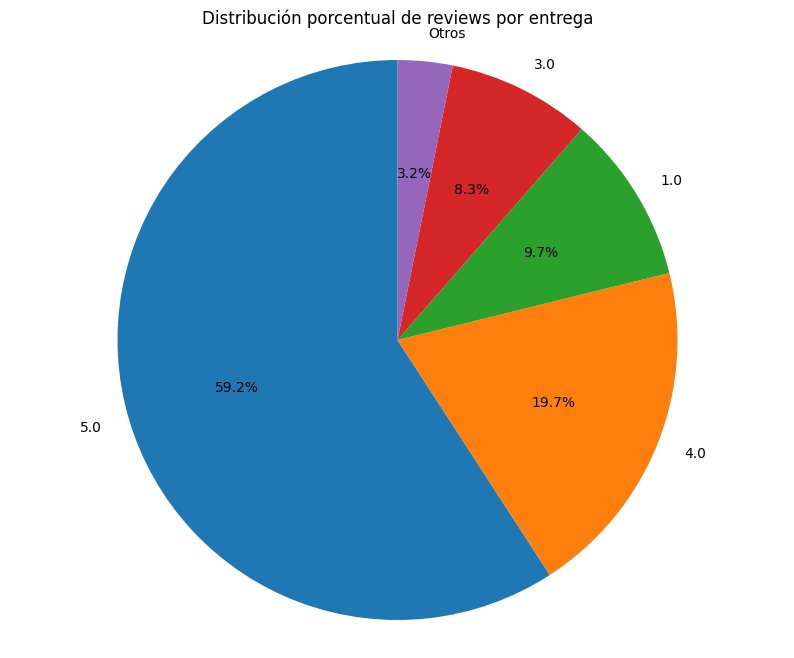

In [22]:
data = df['review_score'].value_counts(normalize=True) * 100
threshold = 5
small = data[data < threshold].sum()
data_plot = data[data >= threshold]

if small > 0:
    data_plot['Otros'] = small

plt.figure(figsize=(10, 8))
plt.pie(data_plot, labels=data_plot.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribución porcentual de reviews por entrega")
plt.axis('equal')
plt.show()

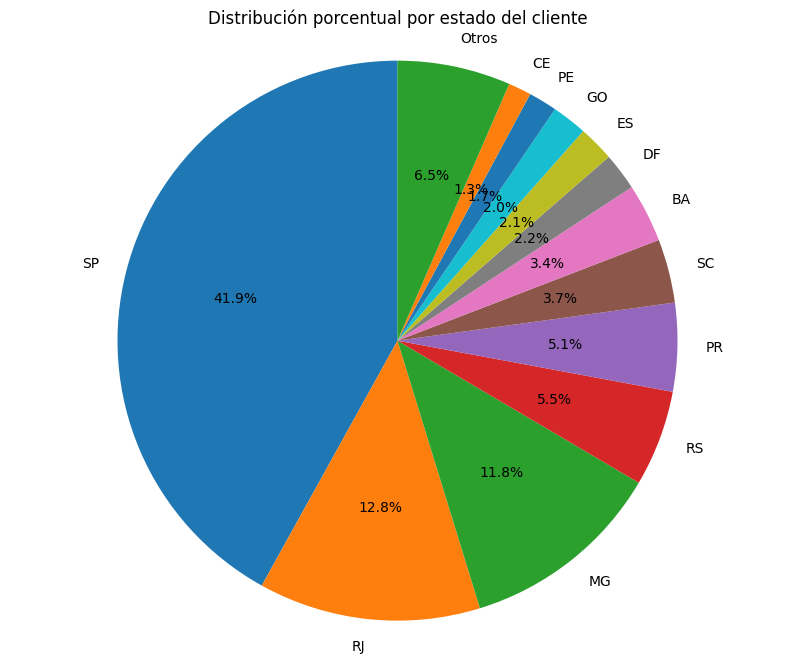

In [23]:
data = df['customer_state'].value_counts(normalize=True) * 100
threshold = 1
small = data[data < threshold].sum()
data_plot = data[data >= threshold]

if small > 0:
    data_plot['Otros'] = small

plt.figure(figsize=(10, 8))
plt.pie(data_plot, labels=data_plot.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribución porcentual por estado del cliente")
plt.axis('equal')
plt.show()

Las categorías con peso porcentual reducido se agrupan para mejorar la legibilidad del gráfico sin perder información relevante.

In [24]:
df['customer_city'].value_counts()

customer_city
sao paulo                15019
rio de janeiro            6602
belo horizonte            2697
brasilia                  2071
curitiba                  1486
                         ...  
taperuaba                    1
senador jose porfirio        1
miraguai                     1
teixeira                     1
itiquira                     1
Name: count, Length: 4085, dtype: int64

In [25]:
df['order_status'].value_counts()

order_status
delivered    96395
canceled         6
Name: count, dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96401 entries, 0 to 96400
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96401 non-null  object        
 1   customer_id                    96401 non-null  object        
 2   order_status                   96401 non-null  object        
 3   order_purchase_timestamp       96401 non-null  datetime64[ns]
 4   order_approved_at              96401 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96400 non-null  datetime64[ns]
 6   order_delivered_customer_date  96401 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96401 non-null  datetime64[ns]
 8   delivery_time_days             96401 non-null  float64       
 9   customer_unique_id             96401 non-null  object        
 10  customer_zip_code_prefix       96401 non-null  int64         
 11  customer_city  

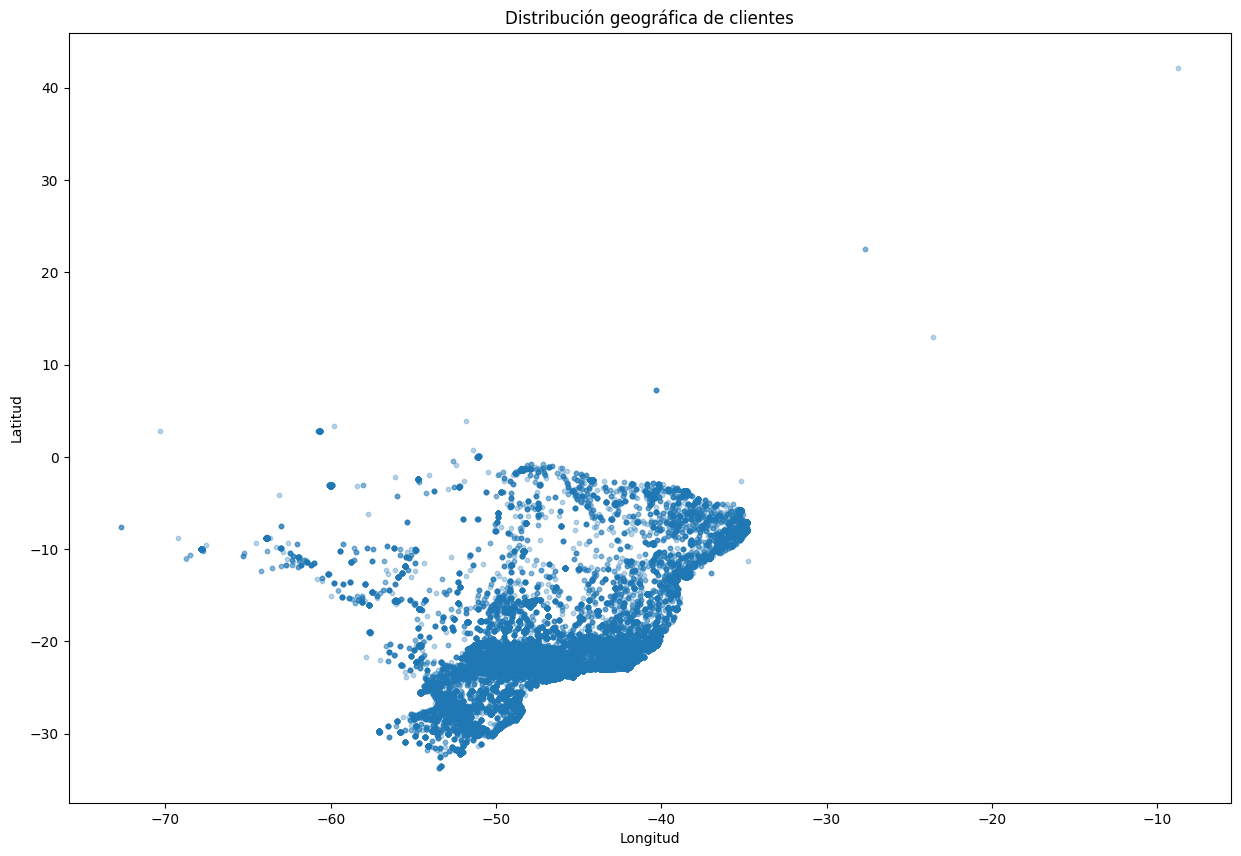

In [27]:
plt.figure(figsize=(15, 10))
plt.scatter(df["geo_lng"], df["geo_lat"], alpha=0.3, s=10)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución geográfica de clientes")
plt.show()

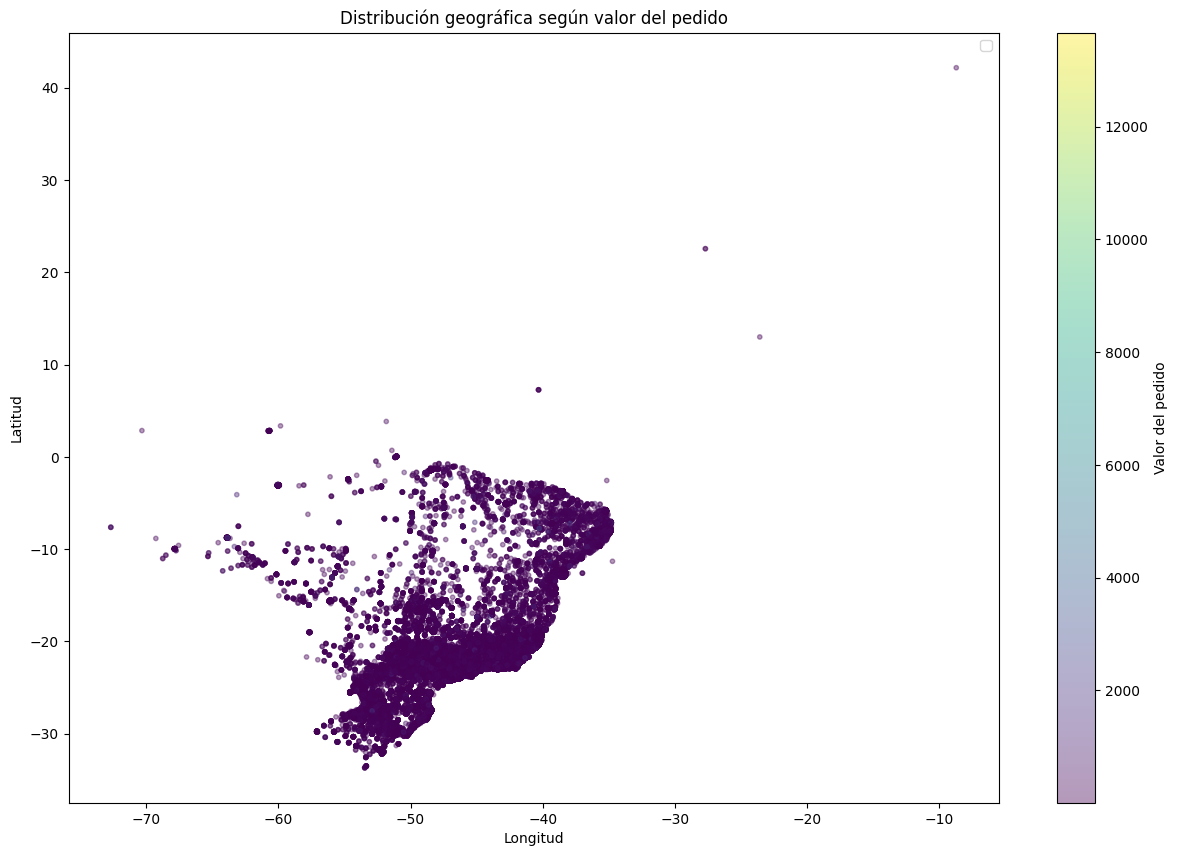

In [28]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(df["geo_lng"], df["geo_lat"], c=df["payment_value"], alpha=0.4, s=10)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución geográfica según valor del pedido")
plt.colorbar(scatter, label="Valor del pedido")
plt.legend()
plt.show()


## Analisis de mi target. 

In [29]:
df["delivery_time_days"].head()

0     8.429144
1    12.502292
2     9.382708
3    13.196331
4     2.830938
Name: delivery_time_days, dtype: float64

In [30]:
df["delivery_time_days"].describe()

count    96401.000000
mean        12.139063
std          9.513472
min          0.007662
25%          6.314884
50%          9.857581
75%         15.144965
max        208.500972
Name: delivery_time_days, dtype: float64

In [31]:
df["delivery_time_days"].median()

np.float64(9.857581018518518)

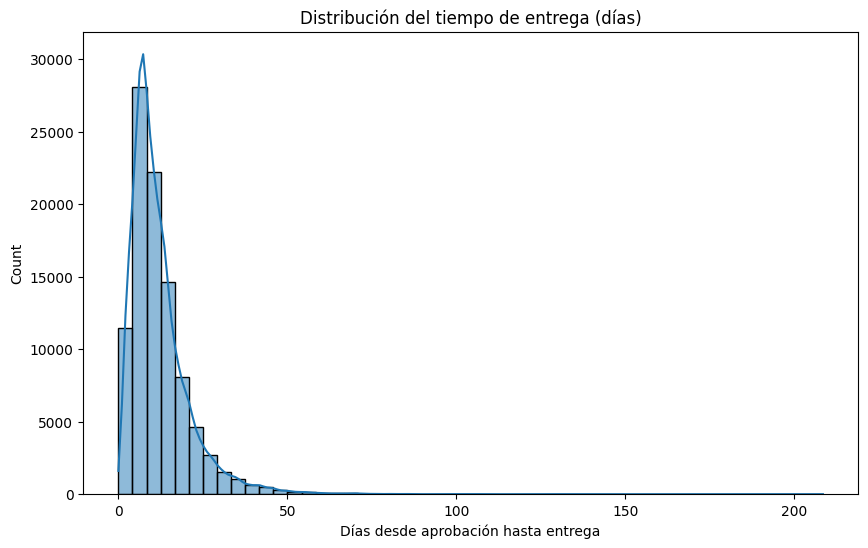

In [32]:
plt.figure(figsize=(10,6))
sns.histplot(df["delivery_time_days"], bins=50, kde=True)
plt.title("Distribución del tiempo de entrega (días)")
plt.xlabel("Días desde aprobación hasta entrega")
plt.show()

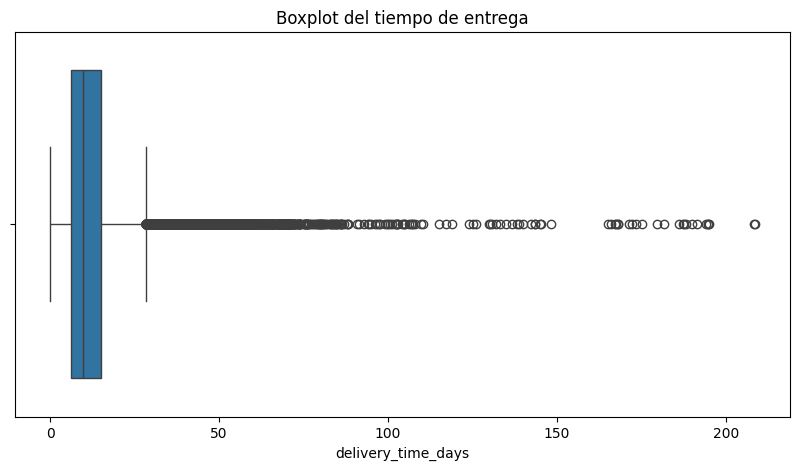

In [33]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["delivery_time_days"])
plt.title("Boxplot del tiempo de entrega")
plt.show()

Visualmente podemos observar la existencia de varios outliers en nuestra variable objetivo.

In [34]:
df_outliers = df[df["delivery_time_days"] >= 50]
df_outliers

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_unique_id,...,customer_state,total_items,total_price,total_freight,payment_value,payment_installments,review_score,main_product_category,geo_lat,geo_lng
107,9d531c565e28c3e0d756192f84d8731f,d4faa220408c20e53595d2950f361f3b,delivered,2017-11-28 21:00:44,2017-12-01 09:31:15,2017-12-14 20:37:43,2018-01-23 21:38:52,2017-12-22,53.505289,efc37ae565ee0943cca2b89fc65c4d6f,...,RJ,1,25.99,14.10,40.09,4.0,1.0,furniture_decor,-22.956593,-42.883494
112,8fc207e94fa91a7649c5a5dab690272a,c69f8b33e62ecb30ff78ae46d7fb9241,delivered,2017-11-26 17:49:46,2017-11-26 17:58:34,2017-11-28 23:17:09,2018-01-20 13:42:22,2017-12-19,54.822083,7d185d821a11c769636247766f1fd45e,...,RJ,1,109.90,25.61,135.51,5.0,3.0,bed_bath_table,-22.784016,-43.397032
244,f31535f21d145b2345e2bf7f09d62322,ed532487db04478dfba09d112649fc13,delivered,2018-02-01 07:47:34,2018-02-01 08:10:31,2018-02-02 00:24:34,2018-04-23 15:49:34,2018-03-05,81.318785,51ac8560948d44d4ffa33f2680569a20,...,RJ,1,199.00,24.26,223.26,5.0,1.0,auto,-22.940617,-43.065454
428,690199d6a2c51ff57c6b392d7680cbfd,19bacb562bd43bd4eaf05b6c0a59dad0,delivered,2018-03-16 11:31:18,2018-03-16 11:49:14,2018-03-19 19:56:23,2018-05-14 12:28:56,2018-04-11,59.027569,c5f01991eadc43c924dfd891e9026217,...,PR,1,54.99,18.26,73.25,3.0,5.0,perfumery,NaN,NaN
635,cafc9b2f7d35ec42bdb74347cc6e8a70,c9573cc1e246dadca50b2a74f795def3,delivered,2018-01-19 00:48:30,2018-01-19 01:21:52,2018-01-19 22:41:38,2018-04-04 17:12:36,2018-02-16,75.660231,7671178c592895e5beed747367b4a54b,...,CE,1,38.00,17.63,55.63,1.0,1.0,stationery,-3.795724,-38.470373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95224,2e56f943f231f5fe108f43fb370b0ed6,66b9bc2d53ea09b027966337424fa0c7,delivered,2017-02-09 12:12:22,2017-02-09 12:32:26,2017-02-14 14:00:48,2017-05-25 07:14:44,2017-03-16,104.779375,d6e7520f52b7d40e2bb54f05c374225e,...,RJ,1,244.90,23.18,268.08,10.0,5.0,bed_bath_table,-22.969148,-43.383065
95663,8a88cd510147b16da3ff773025a39430,bbabdabac0f425e8c087ec7ed63a7aee,delivered,2017-11-14 12:22:53,2017-11-14 12:35:24,2017-11-29 13:57:40,2018-01-08 23:19:36,2017-12-12,55.447361,a897335a844c6cb0c0f25a75f43092b4,...,MA,1,65.00,38.00,103.00,2.0,1.0,food_drink,-3.276285,-45.654905
95703,63fd40b25ac9dbeea8ec6b26558a1add,23e74e2cca6193a0e238483464222068,delivered,2018-02-11 17:49:44,2018-02-11 18:08:18,2018-02-14 21:38:58,2018-04-20 23:08:27,2018-03-09,68.208438,30fac3a7d72060742bcbe7b787617343,...,RJ,1,227.99,50.34,278.33,1.0,2.0,home_appliances_2,-22.864355,-43.434757
95740,32fef9bb0f0402350b640eb6f13dbe09,28c857caf2f37bb8751725b85dac2481,delivered,2018-03-07 06:46:21,2018-03-08 02:15:43,2018-03-08 19:54:23,2018-05-03 00:39:55,2018-03-29,55.933472,022130229ad6d7d853447a4b0979b2dd,...,MG,1,97.65,18.56,116.21,1.0,1.0,health_beauty,-19.453668,-42.543942


In [35]:
df_outliers["main_product_category"].value_counts()

main_product_category
bed_bath_table                       77
health_beauty                        60
furniture_decor                      52
sports_leisure                       48
computers_accessories                42
auto                                 40
office_furniture                     30
housewares                           28
watches_gifts                        27
toys                                 25
perfumery                            23
baby                                 22
stationery                           21
cool_stuff                           20
garden_tools                         19
telephony                            17
electronics                          13
consoles_games                       10
fashion_bags_accessories             10
construction_tools_construction       9
food                                  6
pet_shop                              4
small_appliances                      3
home_construction                     3
musical_instrument

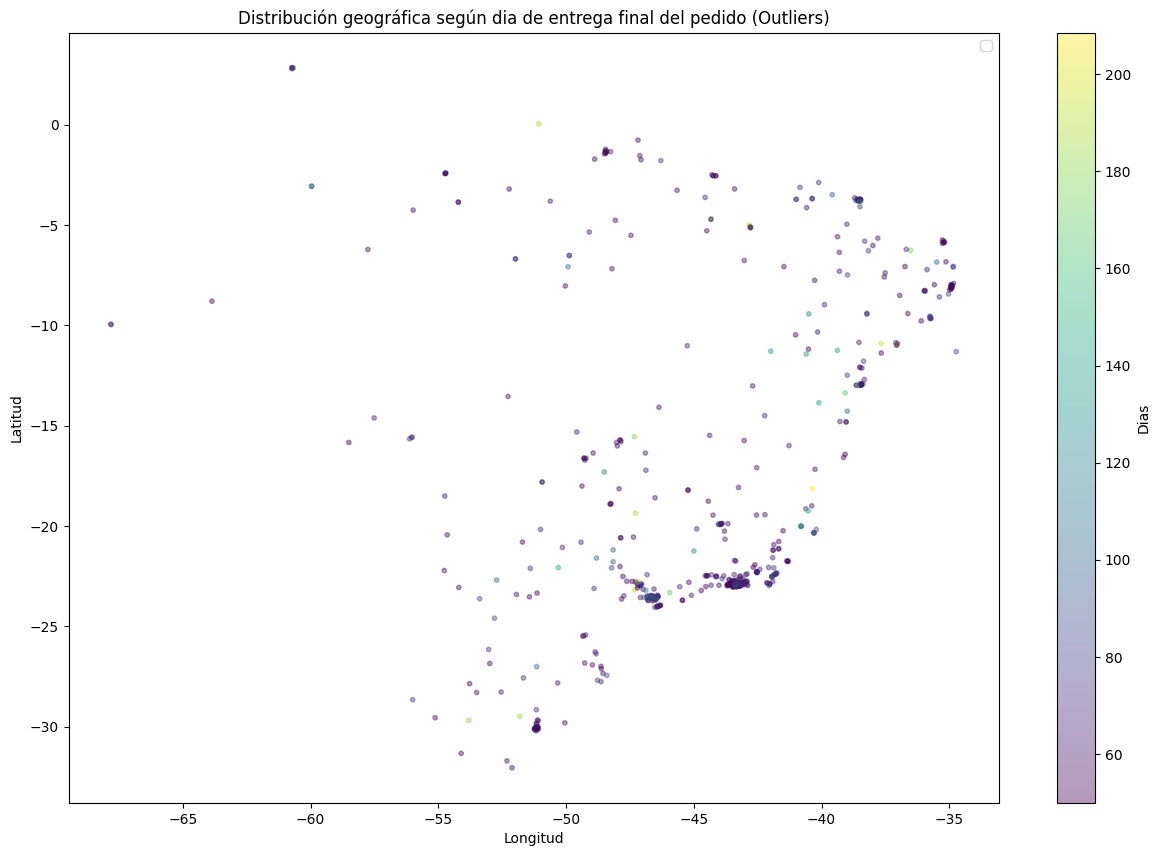

In [36]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(df_outliers["geo_lng"], df_outliers["geo_lat"], c=df_outliers["delivery_time_days"], alpha=0.4, s=10)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución geográfica según dia de entrega final del pedido (Outliers)")
plt.colorbar(scatter, label="Dias")
plt.legend()
plt.show()

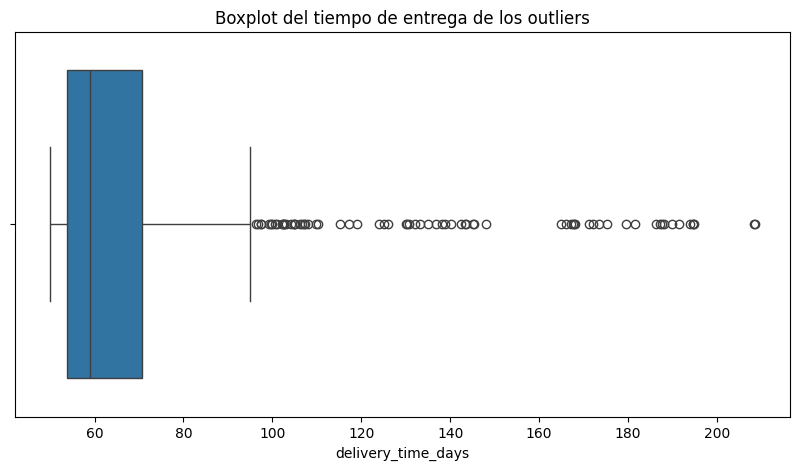

In [37]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_outliers["delivery_time_days"])
plt.title("Boxplot del tiempo de entrega de los outliers")
plt.show()

In [38]:
df_days = df[df["delivery_time_days"] < 50]
df_days

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_unique_id,...,customer_state,total_items,total_price,total_freight,payment_value,payment_installments,review_score,main_product_category,geo_lat,geo_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,7c396fd4830fd04220f754e42b4e5bff,...,SP,1,29.99,8.72,38.71,1.0,4.0,baby,-23.576983,-46.587161
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12.502292,af07308b275d755c9edb36a90c618231,...,BA,1,118.70,22.76,141.46,1.0,4.0,perfumery,-12.177924,-44.660711
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.382708,3a653a41f6f9fc3d2a113cf8398680e8,...,GO,1,159.90,19.22,179.12,3.0,5.0,auto,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.196331,7c142cf63193a1473d2e66489a9ae977,...,RN,1,45.00,27.20,72.20,1.0,5.0,pet_shop,-5.774190,-35.271143
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.830938,72632f0f9dd73dfee390c9b22eb56dd6,...,SP,1,19.90,8.72,28.62,1.0,5.0,stationery,-23.676370,-46.514627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96396,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.218009,6359f309b166b0196dbf7ad2ac62bb5a,...,SP,1,72.00,13.08,85.08,3.0,5.0,health_beauty,-23.178000,-45.883818
96397,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.185637,da62f9e57a76d978d02ab5362c509660,...,SP,1,174.90,20.10,195.00,3.0,4.0,baby,-24.001500,-46.449864
96398,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.847234,737520a9aad80b3fbbdad19b66b37b30,...,BA,1,205.99,65.02,271.01,5.0,5.0,home_appliances_2,-17.898358,-39.373630
96399,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.080938,5097a5312c8b157bb7be58ae360ef43c,...,RJ,2,359.98,81.18,441.16,4.0,2.0,computers_accessories,-22.562825,-42.694574


In [39]:
df_days["delivery_time_days"].describe().T

count    95754.000000
mean        11.752652
std          7.957765
min          0.007662
25%          6.294444
50%          9.802193
75%         15.014491
max         49.994155
Name: delivery_time_days, dtype: float64

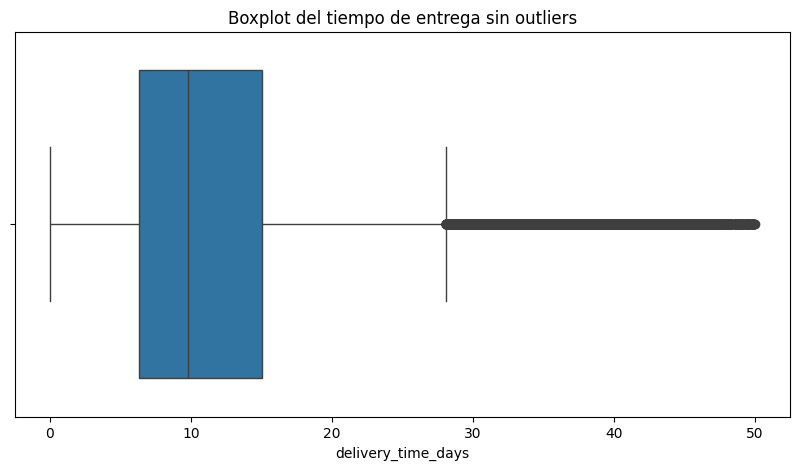

In [40]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_days["delivery_time_days"])
plt.title("Boxplot del tiempo de entrega sin outliers")
plt.show()

## Conclusiones. 

Tras eliminar los outliers con tiempos de entrega iguales o superiores a 50 días, el tiempo promedio de entrega desde la aprobación del pedido hasta la entrega por parte del cliente es de aproximadamente 11,75 días, con una mediana de 9,8 días. El 75 % de los pedidos se entregan en menos de 15 días, lo que indica un comportamiento logístico generalmente eficiente.

In [41]:
df_job = df_days.drop(columns=["order_id","customer_id","customer_unique_id"])
df_job.columns

Index(['order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'delivery_time_days',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'total_items', 'total_price', 'total_freight', 'payment_value',
       'payment_installments', 'review_score', 'main_product_category',
       'geo_lat', 'geo_lng'],
      dtype='object')

In [42]:
df_num = df_job.copy()
df_num ['number_order_status'] = pd.factorize(df_job['order_status'])[0]
df_num ['number_customer_city'] = pd.factorize(df_job['customer_city'])[0]
df_num ['number_main_product_category'] = pd.factorize(df_job['main_product_category'])[0]
df_num ['number_customer_state'] = pd.factorize(df_job['customer_state'])[0]
df_num_factorize = df_num.select_dtypes(include=['number'])

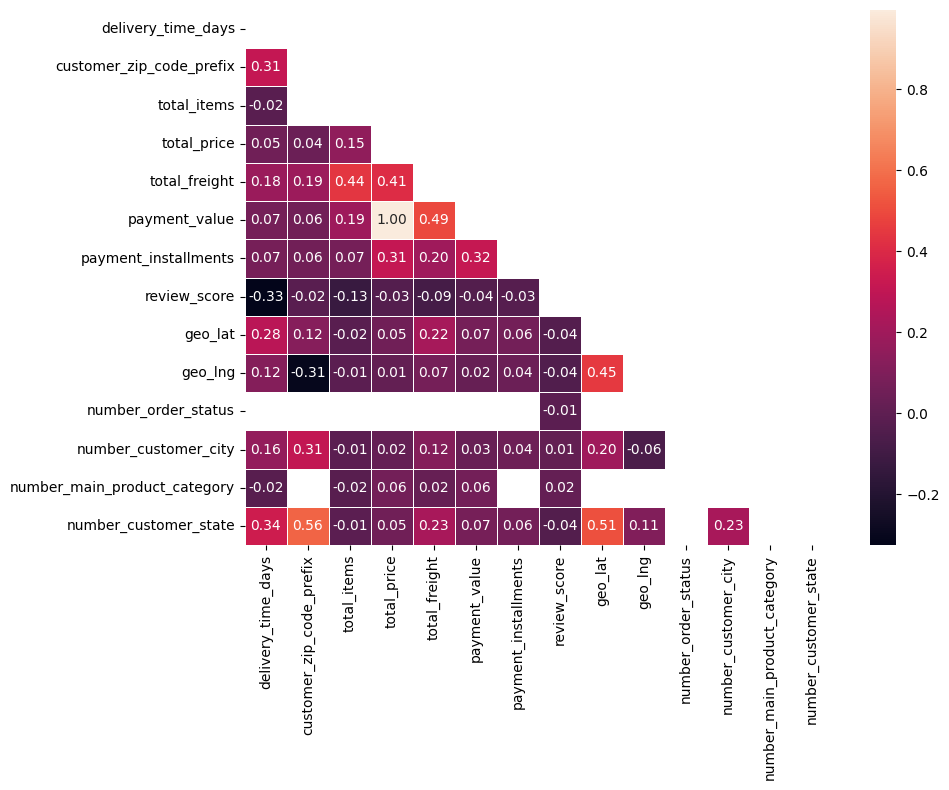

In [43]:
corr = df_num_factorize.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
significant_corr = corr[abs(corr) > 0.01]
significant_corr
fig, axis = plt.subplots(figsize=(10, 8))
sns.heatmap(significant_corr, mask=mask, annot=True, linewidths=0.5, fmt=".2f")
plt.tight_layout()
plt.show()

### Conclusion final.

El análisis de correlación indica que el tiempo de reparto (delivery_time_days) está principalmente relacionado con factores geográficos. Tanto el código postal del cliente, el estado, como las coordenadas geográficas (latitud y longitud) presentan correlaciones moderadas, lo que refuerza la idea de que la ubicación y la distancia son determinantes clave en la duración de la entrega.

Las variables económicas del pedido, como el precio total, el coste de envío y el valor del pago, muestran una relación positiva pero débil con el tiempo de reparto, indicando que pedidos más caros o con mayor coste logístico tienden a tardar ligeramente más, aunque no son factores decisivos.

Por otro lado, se mantiene una correlación negativa entre el tiempo de reparto y la puntuación de la reseña, confirmando que entregas más lentas están asociadas a una peor valoración por parte del cliente.

En conjunto, los resultados sugieren que el tiempo de reparto depende en mayor medida de variables logísticas y de localización, mientras que las características del pedido y del pago tienen un impacto secundario.

In [44]:
df_job["purchase_hour"] = pd.to_datetime(df_job["order_purchase_timestamp"]).dt.hour
df_job["purchase_weekday"] = pd.to_datetime(df_job["order_purchase_timestamp"]).dt.weekday
df_job["approval_delay_hours"] = (pd.to_datetime(df_job["order_approved_at"]) - pd.to_datetime(df_job["order_purchase_timestamp"])).dt.total_seconds() / 3600

In [45]:
df_job = df_job.drop(columns=["order_purchase_timestamp", "order_approved_at", "order_status", "review_score", "order_delivered_customer_date", "order_delivered_carrier_date"])

Las variables eliminadas corresponden a fechas crudas y a información que se conoce después del proceso de entrega. En concreto, order_delivered_customer_date, order_status y review_score se excluyen para evitar fuga de información, ya que están directamente influenciadas por el tiempo de reparto. Por otro lado, las marcas temporales originales (order_purchase_timestamp y order_approved_at) se eliminan tras haber extraído de ellas variables temporales relevantes, evitando introducir ruido y facilitando el aprendizaje del modelo.

Por lo cual procedo a definir cada variable nueva creada: 

>-La variable "approval_delay_hours" representa el tiempo que tarda un pedido en ser aprobado desde el momento en que el cliente realiza la compra.

>-La variable "purchase_hour" indica la hora del día en la que el cliente realizó la compra.

>-La variable "purchase_weekday" indica el día de la semana en el que el cliente realizó la compra.

In [46]:
df_job.columns

Index(['order_estimated_delivery_date', 'delivery_time_days',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'total_items', 'total_price', 'total_freight', 'payment_value',
       'payment_installments', 'main_product_category', 'geo_lat', 'geo_lng',
       'purchase_hour', 'purchase_weekday', 'approval_delay_hours'],
      dtype='object')

### MODELADO

In [47]:
variables_num = ["total_items","total_price","total_freight","payment_value",
                 "payment_installments","geo_lat","geo_lng",
                 "purchase_hour","purchase_weekday","approval_delay_hours"]

variables_cate = ["customer_city","customer_state",
                  "main_product_category","customer_zip_code_prefix"]

In [48]:
target = "delivery_time_days"

df_model = df_job[variables_num + variables_cate + [target]].dropna()


## Guardado de los datos para modelado

Una vez tenemos el dataset listo para modelar procedemos a guardar los datos como .csv para su posterior adaptación de variables en Streamlit.

In [49]:
processed_dir = Path("..") / "data" / "processed"#desde notebooks
processed_dir.mkdir(parents=True, exist_ok=True)#crea las carpetas si no existen

df_model.to_csv(processed_dir / "df_model.csv", index=False)#guardado
processed_dir / "df_model.csv"


PosixPath('../data/processed/df_model.csv')

### SPLIT

In [50]:
X = df_model[variables_num + variables_cate]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### PROCESADO

In [51]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), variables_num),
                  ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), variables_cate)])

### Pipelines de modelos

In [52]:
pipe_linear = Pipeline(steps=[("preprocessor", preprocessor),
                              ("model", LinearRegression())])

pipe_ridge = Pipeline(steps=[("preprocessor", preprocessor),
                             ("model", Ridge(alpha=1))])

pipe_lasso = Pipeline(steps=[("preprocessor", preprocessor),
                             ("model", Lasso(alpha=0.001))])

### Entrenamiento

In [53]:
pipe_linear.fit(X_train, y_train)
pipe_ridge.fit(X_train, y_train)
pipe_lasso.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

### Evaluación de modelos.

In [54]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {"MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R2": r2_score(y_test, y_pred)}

linear_metrics = evaluate_model(pipe_linear, X_test, y_test)
ridge_metrics = evaluate_model(pipe_ridge, X_test, y_test)
lasso_metrics = evaluate_model(pipe_lasso, X_test, y_test)

linear_metrics, ridge_metrics, lasso_metrics

({'MAE': 5.353026667416601,
  'RMSE': np.float64(7.461753909930511),
  'R2': 0.12152123832048256},
 {'MAE': 5.188332848537394,
  'RMSE': np.float64(7.2039513619033375),
  'R2': 0.18117523986546058},
 {'MAE': 5.014787707752501,
  'RMSE': np.float64(6.950568284760375),
  'R2': 0.23776295573873263})

Observaciones de los resultados: 

>- MAE mide el error medio en días; valores de 4–6 días son normales en Olist.

>- RMSE penaliza errores grandes, indicando la presencia de entregas atípicas.

>- Un R² bajo es esperado en este baseline y sirve como punto de comparación

# Comparación final de resultados

In [55]:
comparison = pd.DataFrame({"Linear": linear_metrics,
                           "Ridge": ridge_metrics,
                           "Lasso": lasso_metrics})

comparison

,Linear,Ridge,Lasso
MAE,5.353027,5.188333,5.014788
RMSE,7.461754,7.203951,6.950568
R2,0.121521,0.181175,0.237763


### Conclusión de las metricas. 

La regresión lineal básica tiene un rendimiento limitado (R² ≈ 0.12), lo cual confirma que la relación entre las variables y el tiempo de entrega no es puramente lineal.

Ridge mejora el modelo, reduciendo el error y aumentando el R², lo que indica que la regularización ayuda a manejar la multicolinealidad y el ruido.

- Lasso es el mejor modelo:

>- Menor MAE y RMSE → predicciones más precisas.

>- Mayor R² (≈ 0.24) → explica más del doble de variabilidad que el modelo lineal.

## Random Forest

### Preprocesador

In [56]:
preprocessor_rf = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), variables_cate)],remainder="passthrough") 

In [57]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=15,
                           min_samples_leaf=10,
                           random_state=42,
                           n_jobs=-1)

Estos hiperparámetros:

>- Evitan overfitting
>- Controlan memoria

### Pipeline.

In [58]:
pipe_rf = Pipeline(steps=[("preprocessor", preprocessor_rf), ("model", rf)])

### Entrenamiento.

In [59]:
pipe_rf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains 

### Evaluación.

In [60]:
y_pred = pipe_rf.predict(X_test)

rf_metrics = {"MAE": mean_absolute_error(y_test, y_pred),
              "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
              "R2": r2_score(y_test, y_pred)}

rf_metrics

{'MAE': 4.81399311418829,
 'RMSE': np.float64(6.764470648238788),
 'R2': 0.2780334838488895}

## Comparación final con los modelos lineales.

In [61]:
comparison_rf = comparison.copy()
comparison_rf["RandomForest"] = rf_metrics
comparison_rf

,Linear,Ridge,Lasso,RandomForest
MAE,5.353027,5.188333,5.014788,4.813993
RMSE,7.461754,7.203951,6.950568,6.764471
R2,0.121521,0.181175,0.237763,0.278033


### Conclusión final.

Los modelos lineales presentan un rendimiento limitado para predecir el tiempo de entrega. La regularización con Ridge y Lasso mejora ligeramente los resultados, pero el modelo Random Forest es el que obtiene el mejor desempeño, con menor error y mayor capacidad explicativa.

Aun así, el valor de R² indica que el tiempo de entrega depende de otros factores externos no incluidos en los datos. Por este motivo, Random Forest se selecciona como el modelo final por ser el más preciso entre los evaluados.

### Guardado del modelo.

In [62]:
with open("../models/random_forest_delivery_time.pkl", "wb") as f:
           pickle.dump(pipe_rf, f)

## Gradient Boosting.

preprocesado.

In [64]:
preprocessor_gb = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), variables_cate)],remainder="passthrough")

Modelo Gradient Boosting.

In [67]:
gbr = GradientBoostingRegressor(n_estimators=200,
                                learning_rate=0.05,
                                max_depth=5,
                                min_samples_leaf=20,
                                random_state=42)

pipeline.

In [68]:
pipe_gb = Pipeline(steps=[("preprocessor", preprocessor_gb),
                          ("model", gbr)])

entrernamiento.

In [69]:
pipe_gb.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains 

Evaluación.

In [70]:
y_pred = pipe_gb.predict(X_test)

gb_metrics = {"MAE": mean_absolute_error(y_test, y_pred),
              "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
              "R2": r2_score(y_test, y_pred)}

gb_metrics

{'MAE': 4.815152035372263,
 'RMSE': np.float64(6.746836740921185),
 'R2': 0.28179268314812544}


comparacion de modelos.

In [71]:
comparison_rf["GradientBoosting"] = gb_metrics
comparison_rf

,Linear,Ridge,Lasso,RandomForest,GradientBoosting
MAE,5.353027,5.188333,5.014788,4.813993,4.815152
RMSE,7.461754,7.203951,6.950568,6.764471,6.746837
R2,0.121521,0.181175,0.237763,0.278033,0.281793


Conclusión.

Elegimos Gradient Boosting como modelo final porque es especialmente potente para datos tabulares y problemas de regresión como el nuestro. Aunque la mejora respecto a Random Forest no es muy grande, obtuvo ligeramente mejores resultados en las métricas de evaluación.

El tiempo de entrega depende de múltiples factores con relaciones no lineales, como la ubicación del cliente, el coste del envío o el tipo de producto. Por ello, los modelos lineales se quedan algo limitados. En cambio, Gradient Boosting es capaz de capturar interacciones complejas entre variables, patrones no lineales y combinaciones de factores que influyen en la duración del envío, lo que lo convierte en una opción más adecuada para este problema.

Guardado del modelo final.

In [ ]:
with open("../models/gradient_boosting_model.pkl", "wb") as f:
    pickle.dump(pipe_gb, f)